In [1]:
#Exercise 2

In [2]:
import wrds
db=wrds.Connection(wrds_username='dariada1')
from datetime import datetime
#db.create_pgpass_file()

Loading library list...
Done


Bullet points:
--------------------------------------------------


b.
The global minimum-variance portfolio (GMV). Give conditions on the means and
covariance matrix of returns for the GMV portfolio to be mean-variance efficient?


Answer:  This is a special case of full mean-variance analysis that does not estimate means; it implicitly assumes that all assets have the same mean. It directly estimates correlation.


c.
The risk parity portfolio with weights equal to the inverse of standard deviations
of returns (RP). Give conditions on the means and covariance matrix for the RP
portfolio to be mean-variance efficient?

Answer: This is also a special case of mean-variance analysis that does not estimate means or correlations; it implicitly assumes that all assets are uncorrelated.


d. The equally weighted portfolio (EW). Give conditions on the means and covariance matrix of returns for the EW portfolio to be mean-variance efficient?

Answer: This has nothing to estimate. It is also a special case of mean-variance analysis; it implicitly assumes that all assets are i.id. (All assets have the same mean and variation and uncorrelated)



 (e) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.005836,0.008608,0.011662,0.012061
Mean Excess Return,0.003490,0.006262,0.009316,0.009714
Std. Dev.,0.074756,0.038396,0.039927,0.041668
Sharpe Ratio,0.046681,0.163082,0.233316,0.233129



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.070034,0.103299,0.139946,0.144728
Mean Excess Return (ann.),0.041876,0.075141,0.111788,0.116569
Std. Dev. (ann.),0.258961,0.133009,0.138312,0.144344
Sharpe Ratio (ann.),0.161707,0.564931,0.808231,0.807583



 (g) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


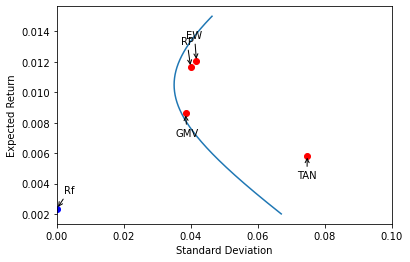


 (h) Cumulative performance of 1$ invested in December 1987:


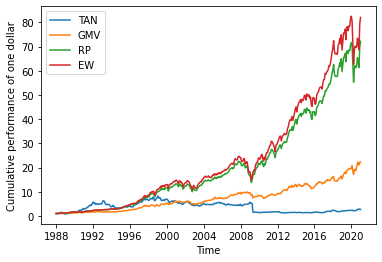

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import datetime
# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1978-01-01'"
            "and mcaldt<='2020-12-31'")
#transform annualized and continuously compounded returns into simple and monthly returns:
#print(data_rf.loc[data_rf.mcaldt >=datetime.date(2015, 1, 1), ['mcaldt','tmytm']])
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={"mcaldt": "date", "tmytm": "rf"})


# get stock returns
data_ret=db.raw_sql("select  permno, date,ret "
           "from crsp.msf "
           "where permno in (11308, 11850, 12490, 14541, 17830, 18163, 18542, 19502, 19561, 21936, 22111, 22592, 22752, 26403, 43449, 47896, 55976, 59176, 59328, 59459) "
           "and date>='1978-01-01'"
            "and date<='2020-12-31'")
numlist=[11308, 11850, 12490, 14541, 17830, 18163, 18542, 19502, 19561, 21936, 22111, 22592, 22752, 26403, 43449, 47896, 55976, 59176, 59328, 59459]


#rearrange data
mask =(data_ret['permno']==numlist[0]) 
data_new=data_ret[mask][['date','ret']]
data_new=data_new.rename(columns={"ret": numlist[0]})
for com in range(1,20):
    mask =(data_ret['permno']==numlist[com]) 
    temp=pd.DataFrame(data_ret[mask][['date','ret']])
    data_new=pd.merge(data_new,temp,on='date')
    data_new=data_new.rename(columns={"ret": numlist[com]})
ret=data_new.set_index(['date'])
Rf=Rf.set_index(['date'])


#compute portfolio weights
roll_mean = ret.rolling(window=120,min_periods=120).mean()
roll_std = ret.rolling(window=120,min_periods=120).std()
roll_cov = ret.rolling(window=120,min_periods=120).cov()
roll_Rf = Rf.rolling(window=120,min_periods=120).mean()

ONES = np.ones(20)

dates = ret.iloc[119:].index.get_level_values(0)

w = np.zeros((len(dates), 4, 20))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_mean.loc[date].values.transpose()
    STD = roll_std.loc[date].values
    SIGMA = roll_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf.loc[date].values
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0)
    w[i,1,:] = (INV_SIGMA@ONES)/A
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum()
    w[i,3,:] = np.ones(20)/20
    i=i+1
    
    
#computing portfolio returns
strategies = ['TAN','GMV','RP','EW']

dates_perf = ret.iloc[120:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret.iloc[120:])
    p_perf[:,j] = tmp.sum(axis=1)

    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf.iloc[120:].mean().values
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12,
                    index_a[1] : E*12,
                    index_a[2] : S*np.sqrt(12),
                    index_a[3] : SR*np.sqrt(12)
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (e) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))

#MV frontiers
Mup = np.linspace(0.002,0.015,1000)
MU = ret.loc[dates_perf].mean().values
SIGMA = ret.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)

A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.1)

plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (g) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()

#total return index
dates_cumperf = ret.iloc[119:].index.get_level_values(0)
cumperf = np.cumprod(np.concatenate((ONES[0:4].reshape(1,4),1+p_perf),axis=0),axis=0)
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend(strategies, loc=0)


print('\n (h) Cumulative performance of 1$ invested in December 1987:')
plt.show()

EX2 (f):
--------------------------------------------------
The compositions of both the tangency and minimum variance portfolios are rather erratic
and include sizable long/short positions in Treasury/corporate bonds. 
The tangency portfolio is long corporate bonds/short treasuries in the first half of the sample, 
while the minimum variance portfolio has a reverse position in bonds for almost the whole sample. 
The weights of the risk parity portfolio are much more stable.

In terms of performance, the tangency (TAN) portfolio is quite clearly outperformed 
by the risk parity (RP) portfolio and the minimum-variance (GMV) portfolio. 
Since RP and GMV do not rely on estimated expected returns (which are used by TAN), 
it is plausible that TAN's inferior performance is due to the noise in the expected returns estimates. 

EX2 (g):
--------------------------------------------------
The most striking result is the poor ex-post performance of the TAN portfolio. 
This is surprising, as this is the portfolio maximizing the Sharpe Ratio. 
It seems that the noise in the expected returns estimates 
more than offsets the theoretical benefits of rebalancing one's portfolio 
to take advantage of time-varying expected returns. 

Secondly, the ex-post GMV portfolio is actually quite close to the minimum of the parabola. 
This illustrates the point that it is easier to estimate covariances than means. 

Lastly, note the very strong performance of the RP and EW strategies. 
This is perhaps suprising given the simplicity of the computations of the weights, 
and the fact these computations are not based on mean-variance optimization. 
In the course, you will see what theories have been proposed
to explain the strong historical performance of risk-parity strategies.